Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_panel_src,
    estimate_model_from_scores,
    format_Stan_data,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:

# read data and set scale of system
features_frame = pd.read_csv("uci_wine_example_features.csv")
features_scores = pd.read_csv("uci_wine_example_scores.csv")
# score_name = "quality"
score_name = "linear_score"
m_examples: int = 100
noise_scale = 0.87
position_penalty_scale = -0.7123


know_score: bool = True

In [7]:
features_frame.head()

fixed acidity is red  volatile acidity is red  citric acid is red  \
0                   7.4                     0.70                0.00   
1                   7.8                     0.88                0.00   
2                   7.8                     0.76                0.04   
3                  11.2                     0.28                0.56   
4                   7.4                     0.70                0.00   

   residual sugar is red  chlorides is red  free sulfur dioxide is red  \
0                    1.9             0.076                        11.0   
1                    2.6             0.098                        25.0   
2                    2.3             0.092                        15.0   
3                    1.9             0.075                        17.0   
4                    1.9             0.076                        11.0   

   total sulfur dioxide is red  density is red  pH is red  sulphates is red  \
0                         34.0          0.9978       3.51              0.56   
1                         67.0          0.9968       3.20              0.68   
2                         54.0          0.9970       3.26              0.65   
3                         60.0          0.9980       3.16              0.58   
4                         34.0          0.9978       3.51              0.56   

   ...  citric acid is white  residual sugar is white  chlorides is white  \
0  ...                   0.0                      0.0                 0.0   
1  ...                   0.0                      0.0                 0.0   
2  ...                   0.0                      0.0                 0.0   
3  ...                   0.0                      0.0                 0.0   
4  ...                   0.0                      0.0                 0.0   

   free sulfur dioxide is white  total sulfur dioxide is white  \
0                           0.0                            0.0   
1                           0.0                            0.0   
2                           0.0                            0.0   
3                           0.0                            0.0   
4                           0.0                            0.0   

   density is white  pH is white  sulphates is white  alcohol is white  is_red  
0               0.0          0.0                 0.0               0.0     1.0  
1               0.0          0.0                 0.0               0.0     1.0  
2               0.0          0.0                 0.0               0.0     1.0  
3               0.0          0.0                 0.0               0.0     1.0  
4               0.0          0.0                 0.0               0.0     1.0  

[5 rows x 23 columns]

In [8]:
features_frame.shape

(6497, 23)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:
position_penalties = [position_penalty_scale * i for i in range(n_alternatives)]

position_penalties

[-0.0, -0.7123, -1.4246, -2.1369000000000002, -2.8492]

In [13]:
# assemble panels of observations with top scoring entry picked
observations = dict()
for sel_i in range(n_alternatives):
    observations[f"display_position_{sel_i}"] = [sel_i] * m_examples
    selected_examples = rng.choice(
        features_frame.shape[0], size=m_examples, replace=True
    )
    observations[f"item_id_{sel_i}"] = selected_examples
    observations[f"score_value_{sel_i}"] = (
        [  # noisy observation of score plus position penalty
            features_scores.loc[int(selected_examples[i]), score_name]  # item score
            + position_penalties[sel_i]  # positional penalty
            + noise_scale * rng.normal(size=1)[0]  # observation noise
            for i in range(m_examples)
        ]
    )
    observations[f"pick_value_{sel_i}"] = [0] * m_examples
observations = pd.DataFrame(observations)
# mark selections
for i in range(m_examples):
    best_j = 0
    for j in range(1, n_alternatives):
        if (
            observations[f"score_value_{j}"][i]
            > observations[f"score_value_{best_j}"][i]
        ):
            best_j = j
    observations.loc[i, f"pick_value_{best_j}"] = 1
observations

display_position_0  item_id_0  score_value_0  pick_value_0  \
0                    0       1569       4.928211             0   
1                    0       4390       5.938004             1   
2                    0        599       6.171799             1   
3                    0       1392       5.162615             1   
4                    0       2063       5.291350             1   
..                 ...        ...            ...           ...   
95                   0       4428       4.962177             0   
96                   0        804       5.304033             1   
97                   0       1483       5.855889             0   
98                   0        555       6.101552             1   
99                   0        155       5.065845             0   

    display_position_1  item_id_1  score_value_1  pick_value_1  \
0                    1       1754       3.577551             0   
1                    1       2031       4.766118             0   
2                    1       1808       4.699399             0   
3                    1       2324       3.820163             0   
4                    1       6283       4.101379             0   
..                 ...        ...            ...           ...   
95                   1       6181       5.278724             1   
96                   1       4323       5.053228             0   
97                   1       1270       6.698287             1   
98                   1       1235       5.635980             0   
99                   1       1241       5.419742             1   

    display_position_2  item_id_2  score_value_2  pick_value_2  \
0                    2       6425       5.500287             1   
1                    2       2692       5.268956             0   
2                    2         64       3.656855             0   
3                    2       5815       3.329515             0   
4                    2       3610       5.205308             0   
..                 ...        ...            ...           ...   
95                   2       1583       4.077900             0   
96                   2       3548       4.280317             0   
97                   2       3348       5.369143             0   
98                   2        905       3.879249             0   
99                   2        831       4.385981             0   

    display_position_3  item_id_3  score_value_3  pick_value_3  \
0                    3       2780       2.036071             0   
1                    3       4416       5.457220             0   
2                    3         59       3.152100             0   
3                    3       1819       4.936617             0   
4                    3       2085       2.792237             0   
..                 ...        ...            ...           ...   
95                   3       1653       4.199244             0   
96                   3       4637       3.754333             0   
97                   3       5643       3.986587             0   
98                   3       6382       3.726882             0   
99                   3       3051       4.372727             0   

    display_position_4  item_id_4  score_value_4  pick_value_4  
0                    4       2646       3.041334             0  
1                    4       1913       4.492735             0  
2                    4       1671       2.246800             0  
3                    4       4567       3.593008             0  
4                    4       5610       4.195280             0  
..                 ...        ...            ...           ...  
95                   4       1098       2.892543             0  
96                   4        798       3.883174             0  
97                   4       3384       4.024738             0  
98                   4       3148       2.756548             0  
99                   4       4506       2.478890             0  

[100 rows x 20 columns]

In [14]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations,
            features_frame=features_frame,
        )

In [15]:
# make sure we don't have a column we would not know in practice
observations = observations.loc[
    :, [c for c in observations.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations.head()

display_position_0  item_id_0  pick_value_0  display_position_1  item_id_1  \
0                   0       1569             0                   1       1754   
1                   0       4390             1                   1       2031   
2                   0        599             1                   1       1808   
3                   0       1392             1                   1       2324   
4                   0       2063             1                   1       6283   

   pick_value_1  display_position_2  item_id_2  pick_value_2  \
0             0                   2       6425             1   
1             0                   2       2692             0   
2             0                   2         64             0   
3             0                   2       5815             0   
4             0                   2       3610             0   

   display_position_3  item_id_3  pick_value_3  display_position_4  item_id_4  \
0                   3       2780             0                   4       2646   
1                   3       4416             0                   4       1913   
2                   3         59             0                   4       1671   
3                   3       1819             0                   4       4567   
4                   3       2085             0                   4       5610   

   pick_value_4  
0             0  
1             0  
2             0  
3             0  
4             0

In [16]:
observations.loc[
    :, [c for c in observations.columns if c.startswith("pick_value_")]
].mean(axis=0)

pick_value_0    0.49
pick_value_1    0.36
pick_value_2    0.09
pick_value_3    0.04
pick_value_4    0.02
dtype: float64

In [17]:
# This is the data
observations[
    [c for c in observations.columns if not c.startswith("display_position_")]
].head(10)

item_id_0  pick_value_0  item_id_1  pick_value_1  item_id_2  pick_value_2  \
0       1569             0       1754             0       6425             1   
1       4390             1       2031             0       2692             0   
2        599             1       1808             0         64             0   
3       1392             1       2324             0       5815             0   
4       2063             1       6283             0       3610             0   
5       2010             1       1465             0       6388             0   
6       5903             1       1374             0        312             0   
7       5194             1       3651             0       1494             0   
8       5946             1       4527             0       5988             0   
9       6469             1       6044             0       2787             0   

   item_id_3  pick_value_3  item_id_4  pick_value_4  
0       2780             0       2646             0  
1       4416             0       1913             0  
2         59             0       1671             0  
3       1819             0       4567             0  
4       2085             0       5610             0  
5         25             0        420             0  
6        926             0       5467             0  
7       1749             0       5865             0  
8       3021             0       4821             0  
9       5786             0       3709             0

In [18]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [19]:
observations_sorted = sort_observations_frame(observations)

In [20]:
observations_sorted.head(10)

encoding_0  item_id_0  pick_value_0  encoding_1  item_id_1  pick_value_1  \
0           2       6425             1           1       1754             0   
1           0       4390             1           1       2031             0   
2           0        599             1           1       1808             0   
3           0       1392             1           1       2324             0   
4           0       2063             1           1       6283             0   
5           0       2010             1           1       1465             0   
6           0       5903             1           1       1374             0   
7           0       5194             1           1       3651             0   
8           0       5946             1           1       4527             0   
9           0       6469             1           1       6044             0   

   encoding_2  item_id_2  pick_value_2  encoding_3  item_id_3  pick_value_3  \
0           0       1569             0           3       2780             0   
1           2       2692             0           3       4416             0   
2           2         64             0           3         59             0   
3           2       5815             0           3       1819             0   
4           2       3610             0           3       2085             0   
5           2       6388             0           3         25             0   
6           2        312             0           3        926             0   
7           2       1494             0           3       1749             0   
8           2       5988             0           3       3021             0   
9           2       2787             0           3       5786             0   

   encoding_4  item_id_4  pick_value_4  
0           4       2646             0  
1           4       1913             0  
2           4       1671             0  
3           4       4567             0  
4           4       5610             0  
5           4        420             0  
6           4       5467             0  
7           4       5865             0  
8           4       4821             0  
9           4       3709             0

In [21]:
observations_sorted[
    [c for c in observations_sorted.columns if not c.startswith("pick_value_")]
].head(10)

encoding_0  item_id_0  encoding_1  item_id_1  encoding_2  item_id_2  \
0           2       6425           1       1754           0       1569   
1           0       4390           1       2031           2       2692   
2           0        599           1       1808           2         64   
3           0       1392           1       2324           2       5815   
4           0       2063           1       6283           2       3610   
5           0       2010           1       1465           2       6388   
6           0       5903           1       1374           2        312   
7           0       5194           1       3651           2       1494   
8           0       5946           1       4527           2       5988   
9           0       6469           1       6044           2       2787   

   encoding_3  item_id_3  encoding_4  item_id_4  
0           3       2780           4       2646  
1           3       4416           4       1913  
2           3         59           4       1671  
3           3       1819           4       4567  
4           3       2085           4       5610  
5           3         25           4        420  
6           3        926           4       5467  
7           3       1749           4       5865  
8           3       3021           4       4821  
9           3       5786           4       3709

In [22]:
assert np.all(observations_sorted["pick_value_0"] == 1)
for sel_i in range(1, n_alternatives):
    assert np.all(observations_sorted[f"pick_value_{sel_i}"] == 0)

In [23]:
stan_model_panel_src = define_Stan_panel_src(n_alternatives=n_alternatives)

if do_display:
    print(stan_model_panel_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

In [24]:
data_str = format_Stan_data(
    observations_sorted=observations_sorted,
    features_frame=features_frame,
)

In [25]:
fit = run_stan_model(
    stan_model_src=stan_model_panel_src,
    data_str=data_str,
)

In [26]:
# get implied sample weights from chain
wt_frame = fit.draws_pd(vars=["lp__"])

wt_frame

lp__
0    -126.977
1    -139.369
2    -139.085
3    -146.693
4    -140.341
...       ...
3995 -144.571
3996 -146.760
3997 -138.586
3998 -141.009
3999 -138.650

[4000 rows x 1 columns]

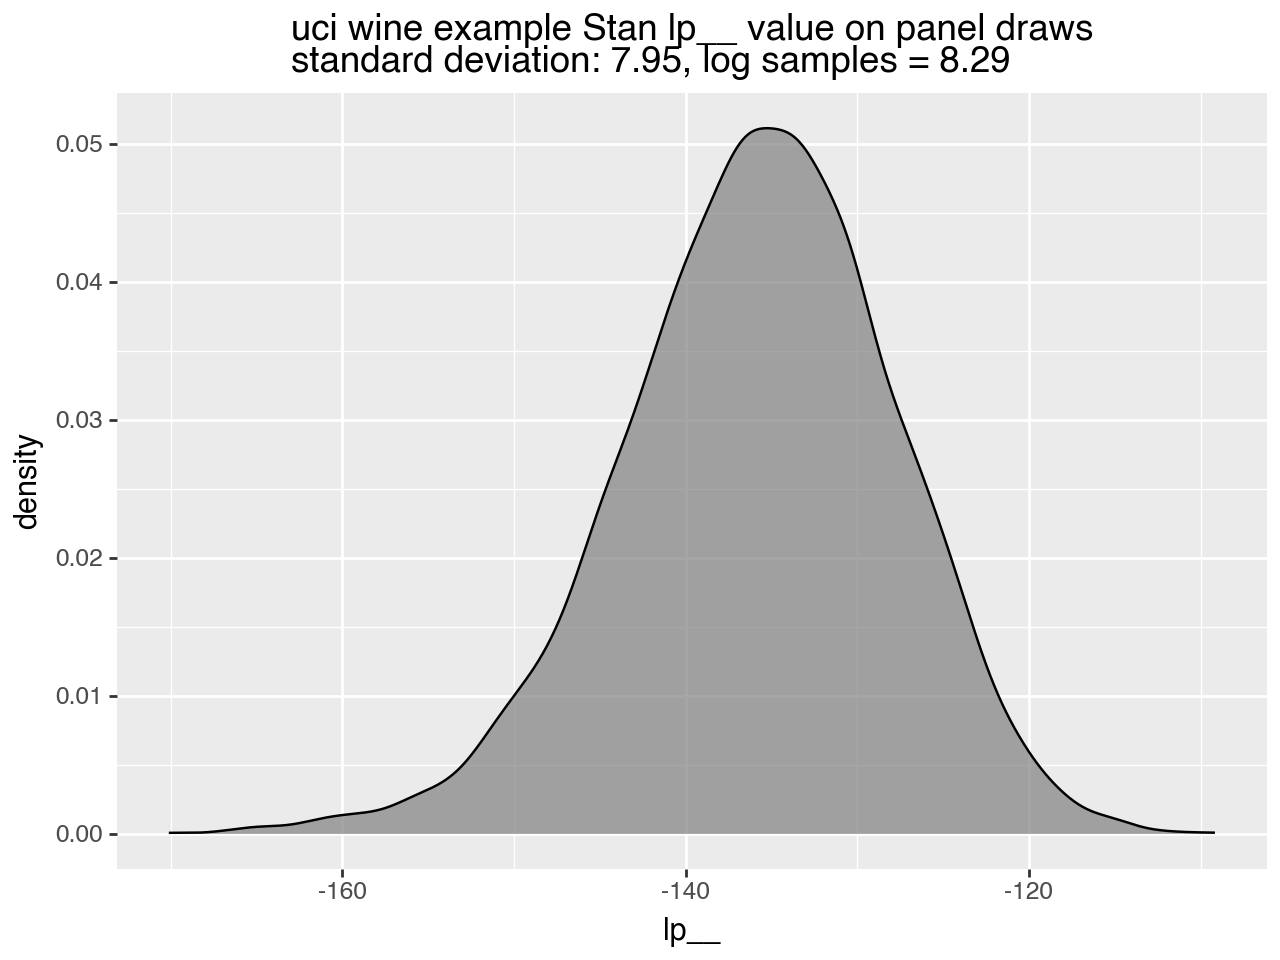

In [27]:
if do_display:
    stddev = np.sqrt(np.var(wt_frame["lp__"]))
    log_samples = np.log(wt_frame.shape[0])
    (
        ggplot(
            data=wt_frame,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on panel draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [28]:
beta_draws = fit.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) + [
    f"position_effect_{sel_i}" for sel_i in range(n_alternatives)
]

beta_draws_display

fixed acidity is red  volatile acidity is red  citric acid is red  \
0                  2.57781                 -4.10348            -6.91311   
1                  1.67890                  3.88963             5.30621   
2                  4.30251                  1.39581           -15.29260   
3                  1.37319                 -3.23599            -7.12840   
4                  3.99872                -10.26870           -14.73150   
...                    ...                      ...                 ...   
3995               4.26148                  4.21716           -19.54550   
3996               1.01016                -10.31770            -4.18932   
3997               3.44649                -12.18270             1.54163   
3998               3.96135                  8.69459           -20.05010   
3999               2.84772                 -8.31213            -1.27182   

      residual sugar is red  chlorides is red  free sulfur dioxide is red  \
0                 -0.920393          -8.83880                    0.645064   
1                  1.060070          -2.98092                    0.423483   
2                 -0.787386           1.85640                    0.247857   
3                 -2.017050         -13.04880                   -0.075149   
4                 -0.874738          28.11620                    0.500103   
...                     ...               ...                         ...   
3995              -1.092400          -8.22692                    0.379673   
3996               0.290797           3.64720                    0.355814   
3997              -1.973880          10.45310                    0.126959   
3998               2.527270          -9.50585                   -0.022939   
3999              -2.166190           7.58649                    0.069348   

      total sulfur dioxide is red  density is red  pH is red  \
0                       -0.388007        3.790060  15.230600   
1                       -0.367046       -3.752630  10.587500   
2                       -0.214264        0.973664 -11.861000   
3                       -0.117253        2.646230  -0.075966   
4                       -0.154551        5.702770  -9.529120   
...                           ...             ...        ...   
3995                    -0.285710        3.856680  -4.737410   
3996                    -0.133407       -2.723490   5.780070   
3997                    -0.196233      -15.594700  16.159900   
3998                    -0.088070       12.951000 -18.260100   
3999                    -0.121643      -12.601600  -1.573050   

      sulphates is red  ...  density is white  pH is white  \
0            25.304100  ...         -1.636820      5.27996   
1            10.385200  ...         -0.823853      7.65084   
2            17.878700  ...        -10.177200      4.34843   
3            -9.840500  ...          9.205640      1.56799   
4            16.347100  ...        -11.159300     12.76260   
...                ...  ...               ...          ...   
3995         20.787300  ...          7.504970      7.67758   
3996         -0.135134  ...         -6.138140      5.72663   
3997         -8.668690  ...          1.234330      9.92424   
3998         26.943400  ...          7.445020     12.86380   
3999         -6.224140  ...         -7.988290     -3.12521   

      sulphates is white  alcohol is white     is_red  position_effect_0  \
0              -7.256980           5.81363   8.019940          11.716700   
1               4.638590           5.24251  14.197600          12.908700   
2               3.941580           2.63669  -9.127670          18.557700   
3               9.861730           3.56156   8.872310           0.381287   
4              16.368100           4.20332   7.481550           4.517740   
...                  ...               ...        ...                ...   
3995           16.189100           6.00080   8.828640           5.153910   
3996            5.776390           3.06585   0.446063     

In [29]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_Stan = beta_draws_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame["lp__"], 0.5), :
].mean()
# estimated_beta_Stan = beta_draws_display.mean()
estimated_beta_Stan

fixed acidity is red              2.592165
volatile acidity is red          -0.887731
citric acid is red               -7.970391
residual sugar is red            -0.909673
chlorides is red                 -1.737722
free sulfur dioxide is red        0.236120
total sulfur dioxide is red      -0.205342
density is red                    1.389200
pH is red                        -1.306944
sulphates is red                  8.542699
alcohol is red                    2.794209
fixed acidity is white           -3.014490
volatile acidity is white        -9.794038
citric acid is white              2.942238
residual sugar is white           0.475197
chlorides is white               -1.025978
free sulfur dioxide is white      0.010500
total sulfur dioxide is white     0.015077
density is white                 -1.340661
pH is white                       7.038553
sulphates is white                8.014850
alcohol is white                  3.685206
is_red                            1.727577
position_ef

In [30]:
position_quantiles = (
    beta_draws.iloc[:, features_frame.shape[1] : n_vars]
    .quantile((0.25, 0.5, 0.75))
    .transpose()
    .reset_index(drop=True, inplace=False)
)
position_quantiles.columns = [str(c) for c in position_quantiles.columns]

estimated position influences


position  estimated effect  actual effect       0.25        0.5       0.75
0   posn_0         12.162929        -0.0000   9.341867  12.431200  15.697750
1   posn_1          7.274126        -0.7123   4.393680   7.548060  10.596375
2   posn_2         -2.562682        -1.4246  -5.798505  -2.543705   0.756149
3   posn_3         -7.476120        -2.1369 -10.987875  -7.561785  -4.008138
4   posn_4        -10.385025        -2.8492 -14.030350 -10.535800  -6.841938

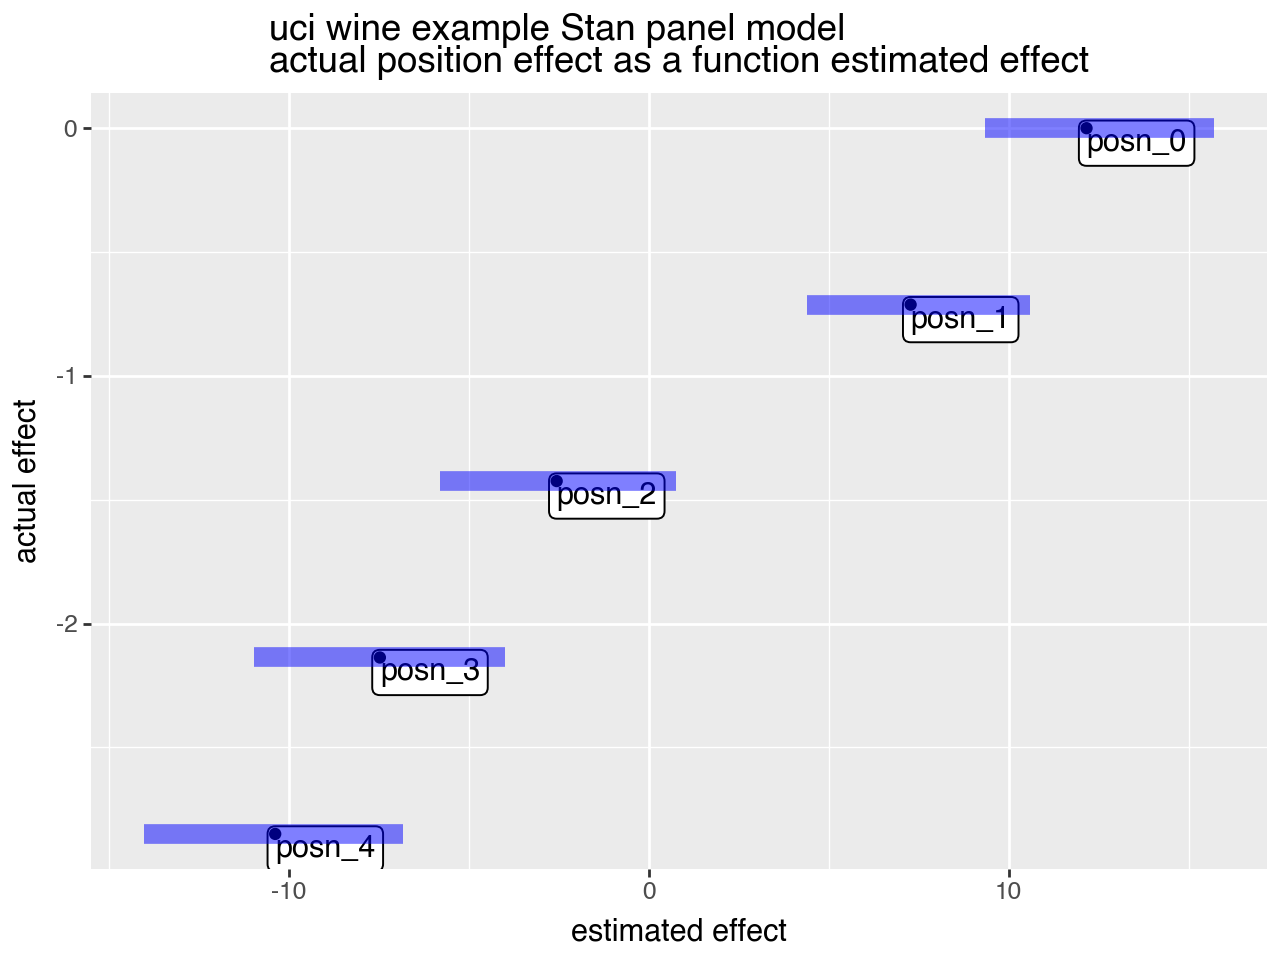

picks


row  position  pick probability estimate  was pick
0    0         0                     0.5634     False
1    0         1                     0.2056     False
2    0         2                     0.2090      True
3    0         3                     0.0148     False
4    0         4                     0.0072     False
5    1         0                     0.5485      True
6    1         1                     0.2655     False
7    1         2                     0.0296     False
8    1         3                     0.1190     False
9    1         4                     0.0374     False

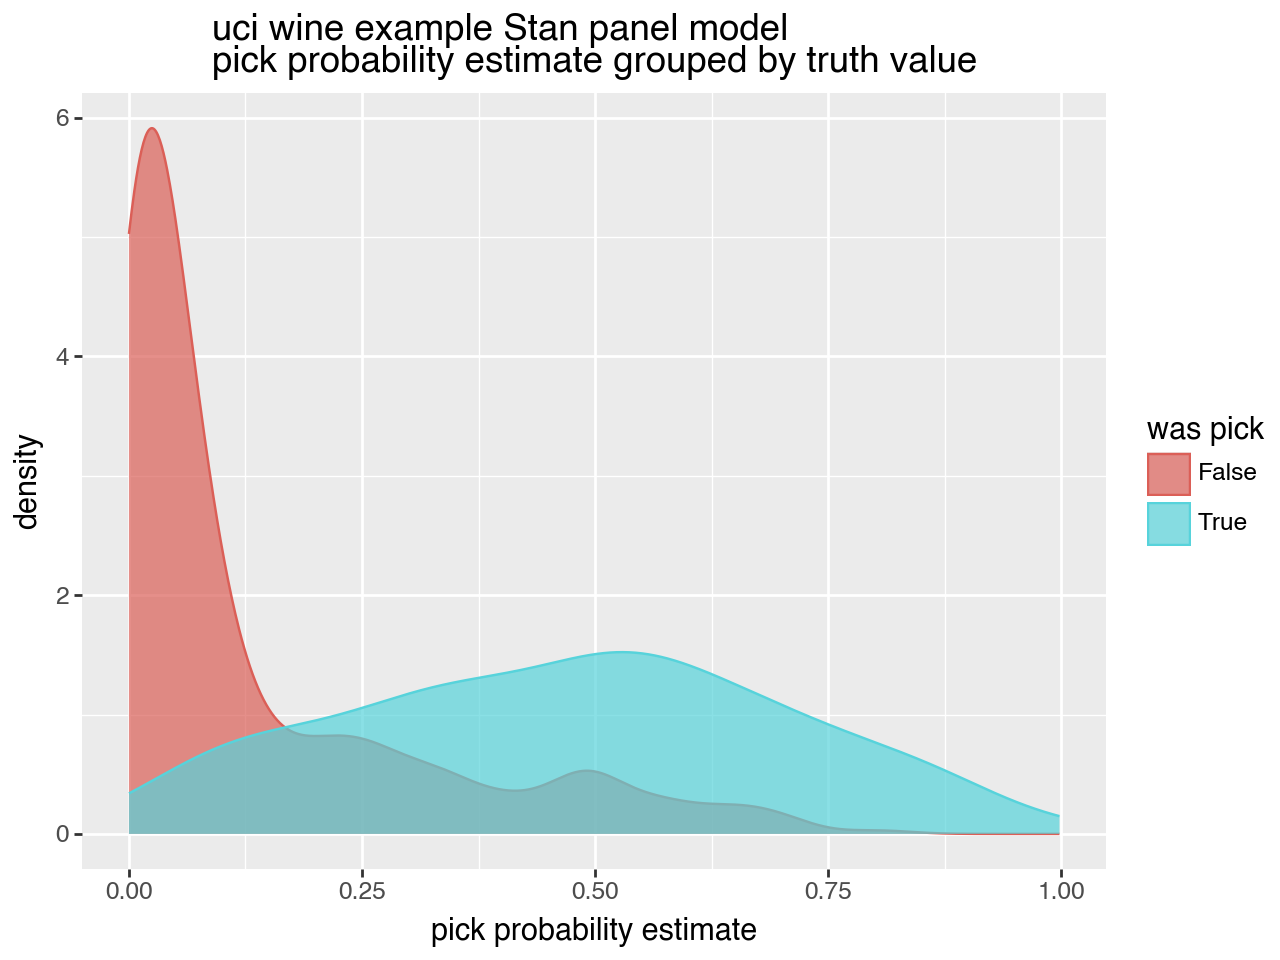

<Figure size 640x480 with 0 Axes>

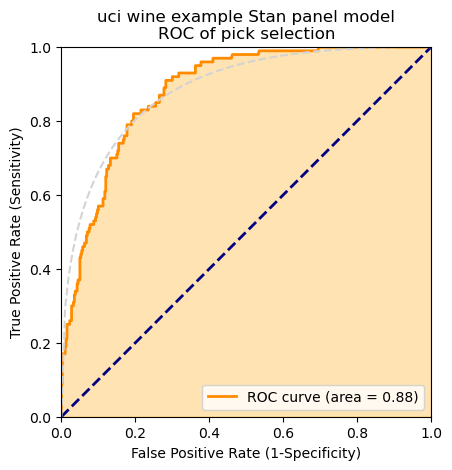

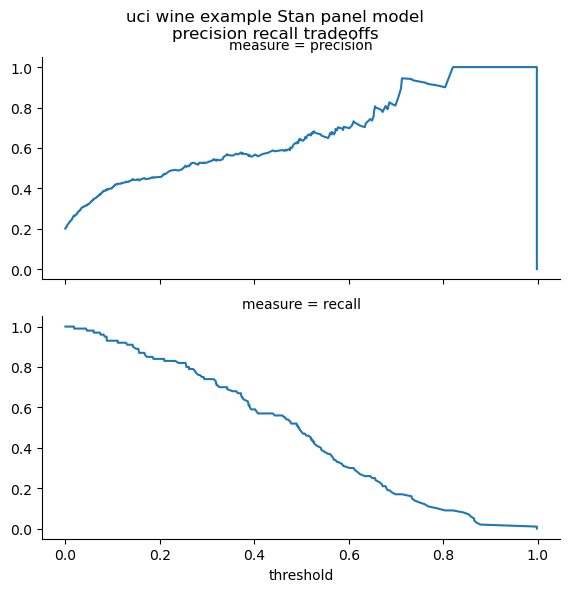

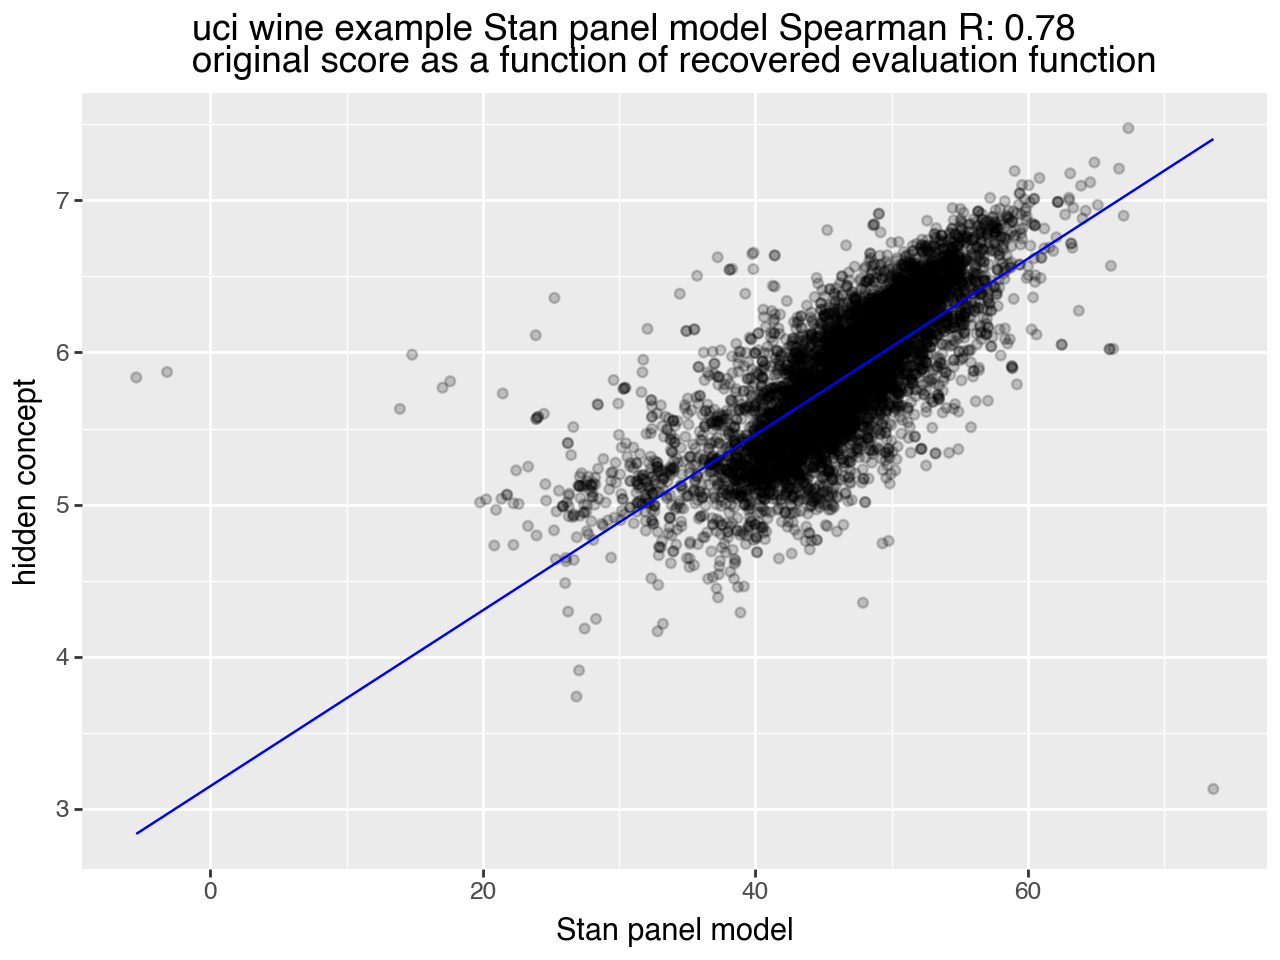

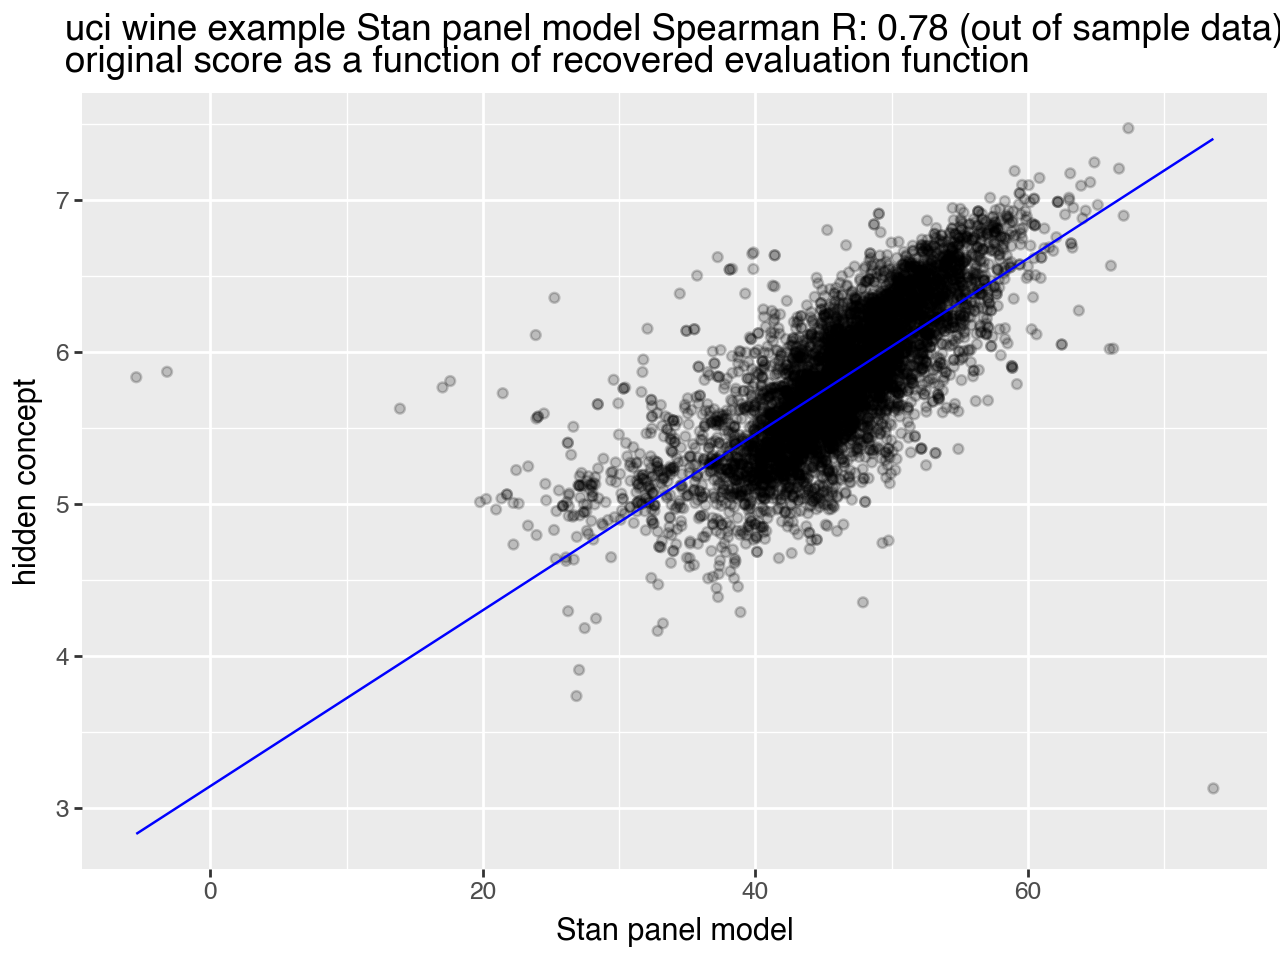

In [31]:
stat_pull = plot_rank_performance(
    estimated_beta=estimated_beta_Stan,  # estimated coefficients
    example_name=example_name,  # name of data set
    n_vars=n_vars,  # number of variables (including position variables)
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations=observations,  # observations layout frame
    estimate_name="Stan panel model",  # display name of estimate
    position_quantiles=position_quantiles,  # quantiles of estimated positions
    position_penalties=position_penalties,  # ideal position penalties
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

Try to approximate the Stan model with a logistic model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [32]:
feature_names = list(features_frame.columns) + [
    f"position_{sel_i}" for sel_i in range(n_alternatives)
]
enc_frame = []
for row_i in range(observations.shape[0]):
    feature_row = observations.loc[row_i, :]
    sel_pick = np.argmax(
        feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
    )
    for sel_i in range(n_alternatives):
        if sel_i != sel_pick:
            posn_vec = [0] * n_alternatives
            posn_vec[sel_pick] = 1.0
            posn_vec[sel_i] = -1.0
            encoded_row = (
                list(
                    features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                    - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                )
                + posn_vec
            )
            di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)

In [33]:
enc_frame.head()

fixed acidity is red  volatile acidity is red  citric acid is red  \
0                  -6.2                    -0.51               -0.14   
1                   0.0                     0.00                0.00   
2                   0.0                     0.00                0.00   
3                   0.0                     0.00                0.00   
4                   0.0                     0.00                0.00   

   residual sugar is red  chlorides is red  free sulfur dioxide is red  \
0                   -1.9            -0.056                       -15.0   
1                    0.0             0.000                         0.0   
2                    0.0             0.000                         0.0   
3                    0.0             0.000                         0.0   
4                    0.0             0.000                         0.0   

   total sulfur dioxide is red  density is red  pH is red  sulphates is red  \
0                        -34.0        -0.99396      -3.48             -0.57   
1                          0.0         0.00000       0.00              0.00   
2                          0.0         0.00000       0.00              0.00   
3                          0.0         0.00000       0.00              0.00   
4                          0.0         0.00000       0.00              0.00   

   ...  density is white  pH is white  sulphates is white  alcohol is white  \
0  ...           0.99462         3.48                0.57              10.7   
1  ...          -0.00328         0.59                0.15               1.8   
2  ...          -0.00138         0.36                0.21               0.6   
3  ...           0.00282         0.41                0.14               0.3   
4  ...           0.00264         0.04               -0.12              -0.7   

   is_red  position_0  position_1  position_2  position_3  position_4  
0    -1.0        -1.0         0.0         1.0         0.0         0.0  
1     0.0         0.0        -1.0         1.0         0.0         0.0  
2     0.0         0.0         0.0         1.0        -1.0         0.0  
3     0.0         0.0         0.0         1.0         0.0        -1.0  
4     0.0         1.0        -1.0         0.0         0.0         0.0  

[5 rows x 28 columns]

In [34]:
logistic_model = LogisticRegression(max_iter=10000, solver="newton-cholesky")
logistic_model.fit(
    pd.concat([enc_frame, -enc_frame], ignore_index=True),
    [True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
)

LogisticRegression(max_iter=10000, solver='newton-cholesky')

estimated position influences


position  estimated effect  actual effect
0   posn_0          1.773619        -0.0000
1   posn_1          1.112133        -0.7123
2   posn_2         -0.290472        -1.4246
3   posn_3         -1.004031        -2.1369
4   posn_4         -1.591250        -2.8492

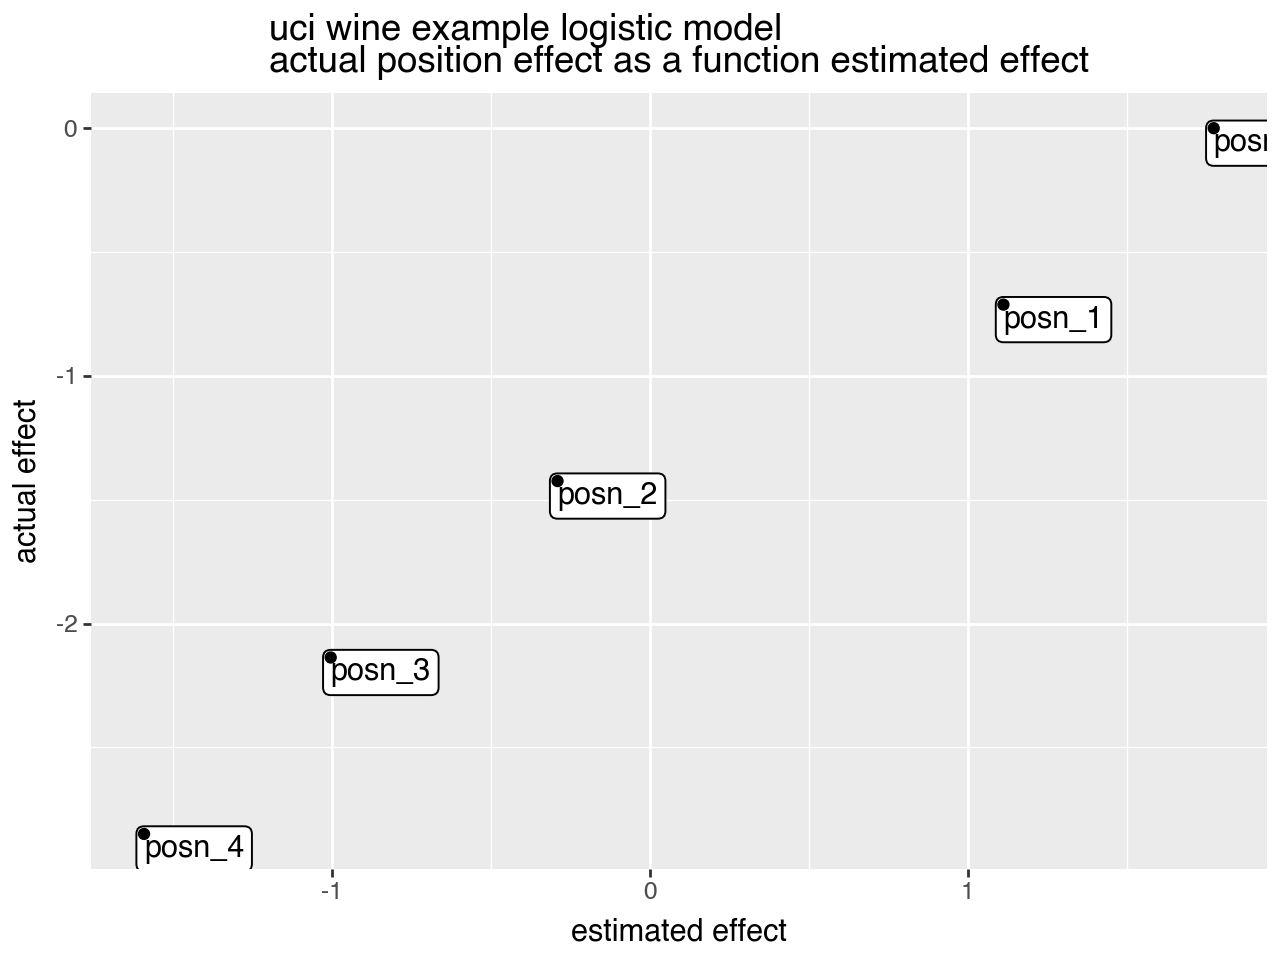

picks


row  position  pick probability estimate  was pick
0    0         0                     0.2480     False
1    0         1                     0.2287     False
2    0         2                     0.2229      True
3    0         3                     0.1601     False
4    0         4                     0.1403     False
5    1         0                     0.2472      True
6    1         1                     0.2224     False
7    1         2                     0.1719     False
8    1         3                     0.1955     False
9    1         4                     0.1630     False

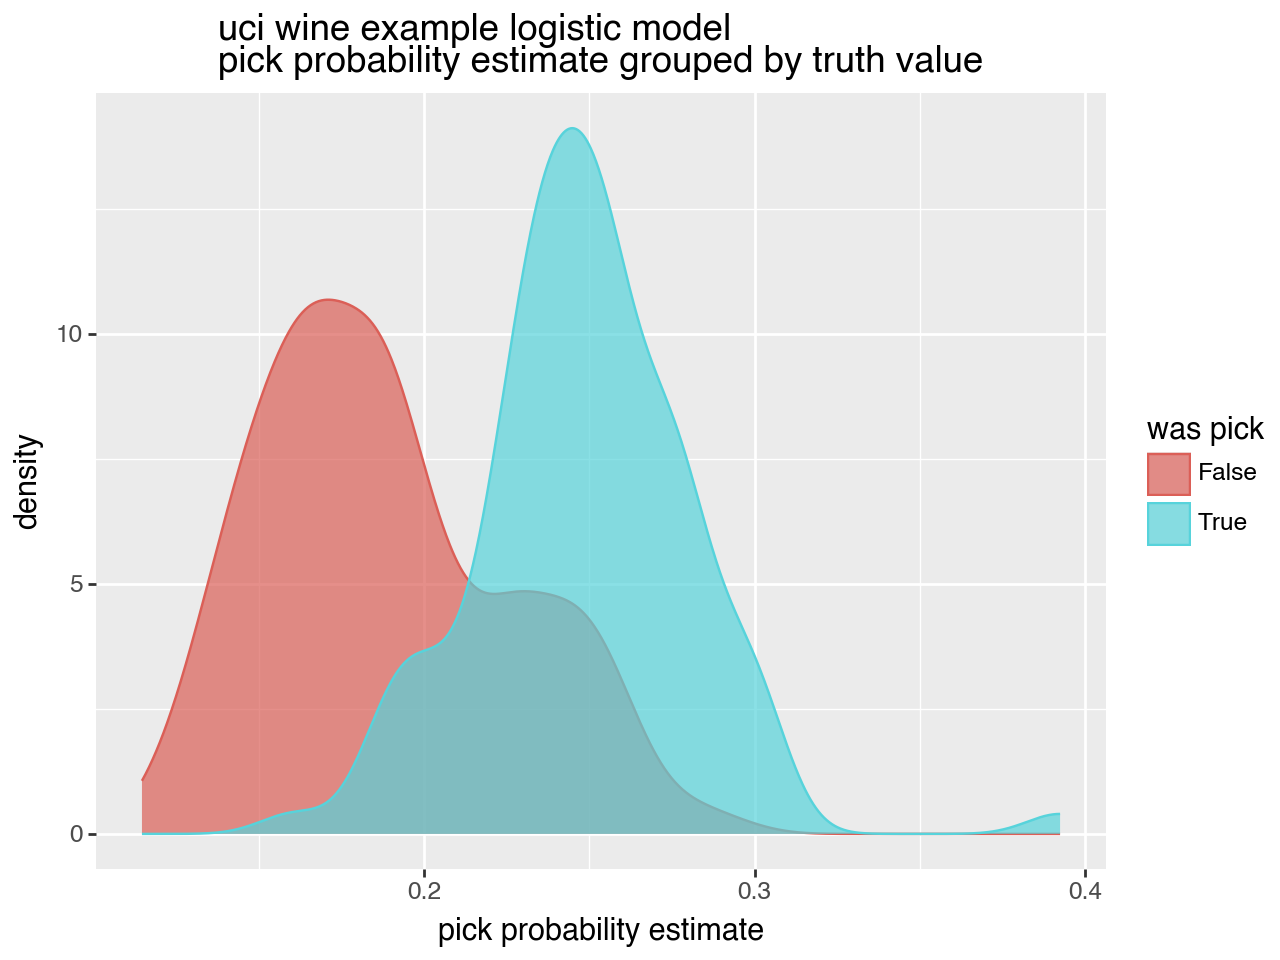

<Figure size 640x480 with 0 Axes>

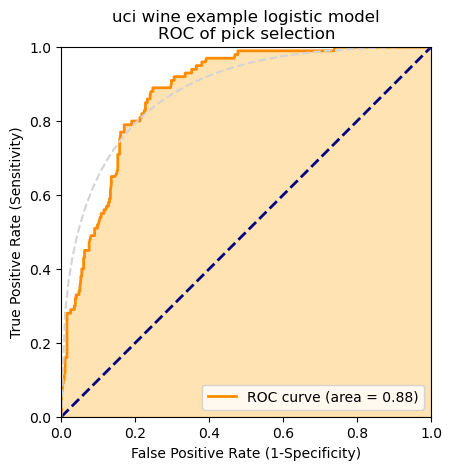

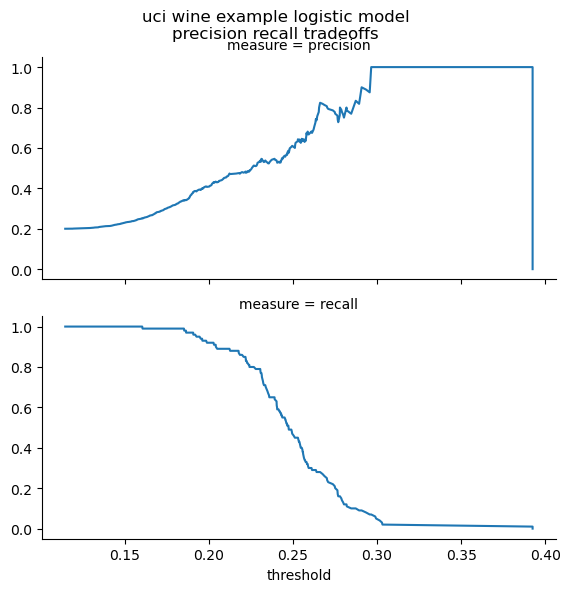

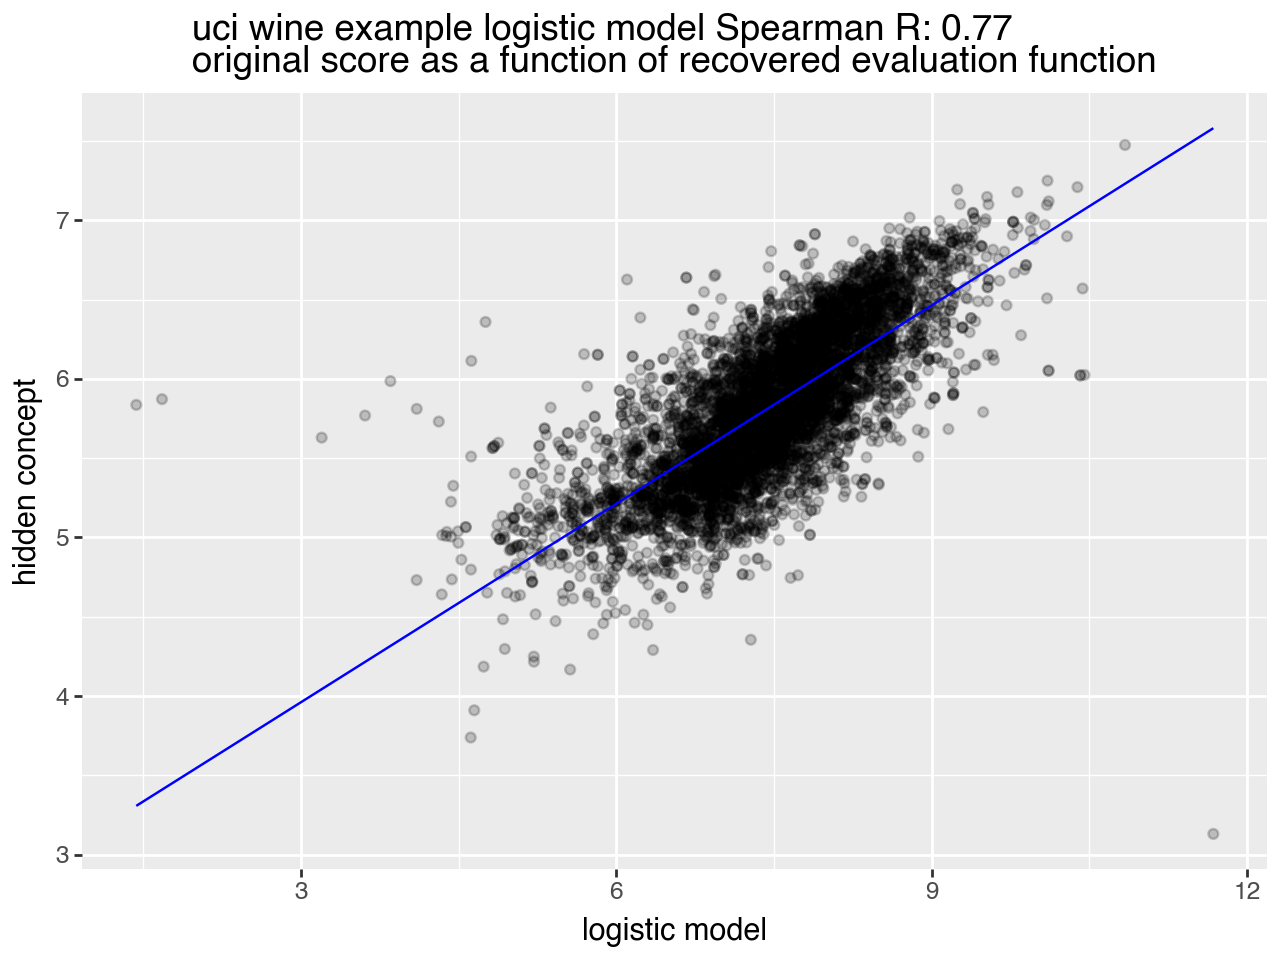

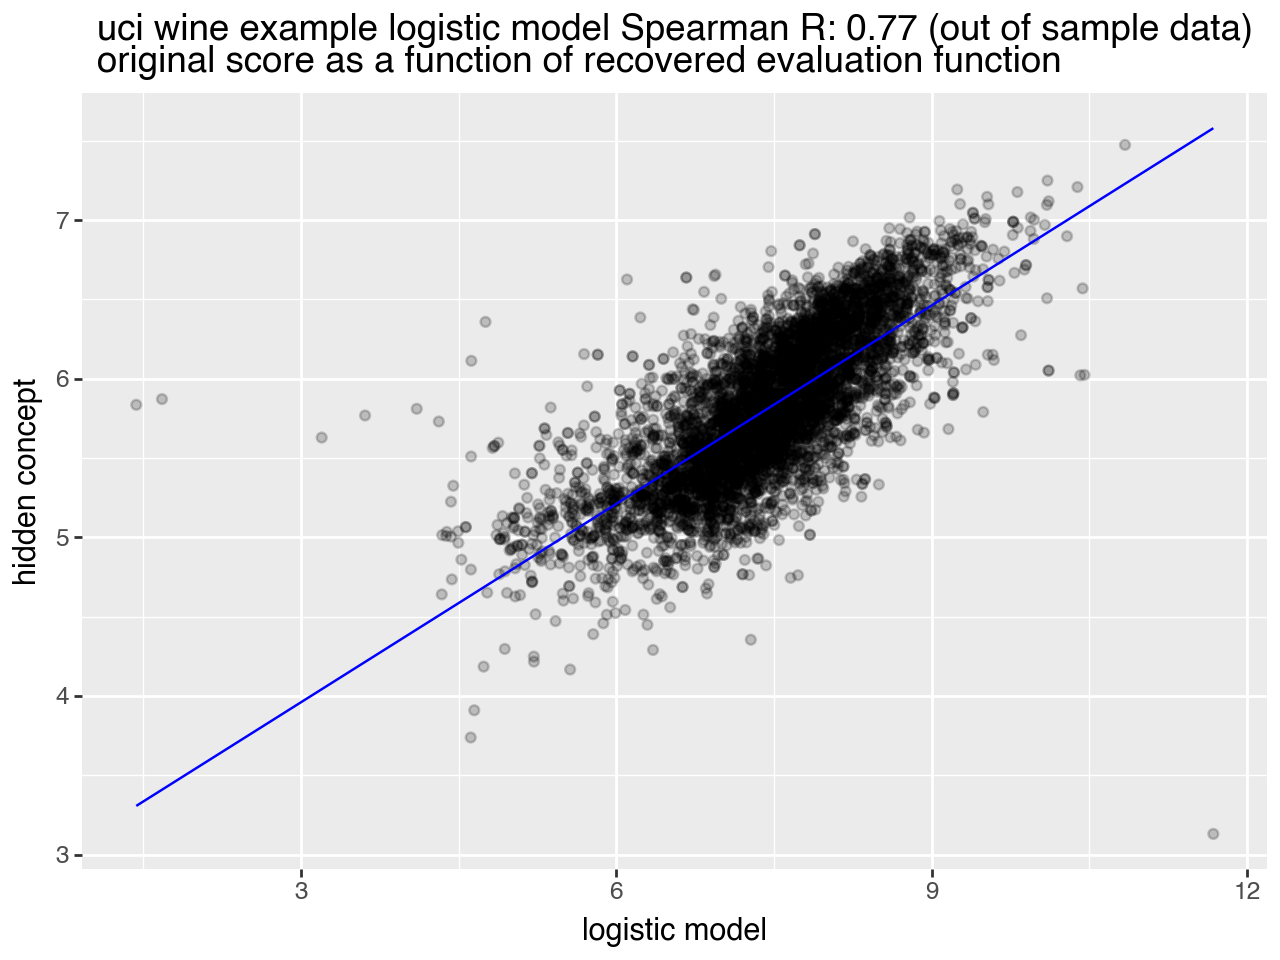

In [35]:
stat_pull = plot_rank_performance(
    estimated_beta=logistic_model.coef_[0],  # estimated coefficients
    example_name=example_name,  # name of data set
    n_vars=n_vars,  # number of variables (including position variables)
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations=observations,  # observations layout frame
    estimate_name="logistic model",  # display name of estimate
    position_quantiles=None,  # quantiles of estimated positions
    position_penalties=position_penalties,  # ideal position penalties
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

We can also try a related Stan model per-comparison, instead of per-panel.

In [36]:
stan_model_comparison_src = define_Stan_choice_src(n_alternatives=n_alternatives)

if do_display:
    print(stan_model_comparison_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // modeled expected score of picked item
  expect_passed_1 = x_passed_1 * beta;      // modeled expected score of passed item
  expe

In [37]:
fit_comp = run_stan_model(
    stan_model_src=stan_model_comparison_src,
    data_str=data_str,
)

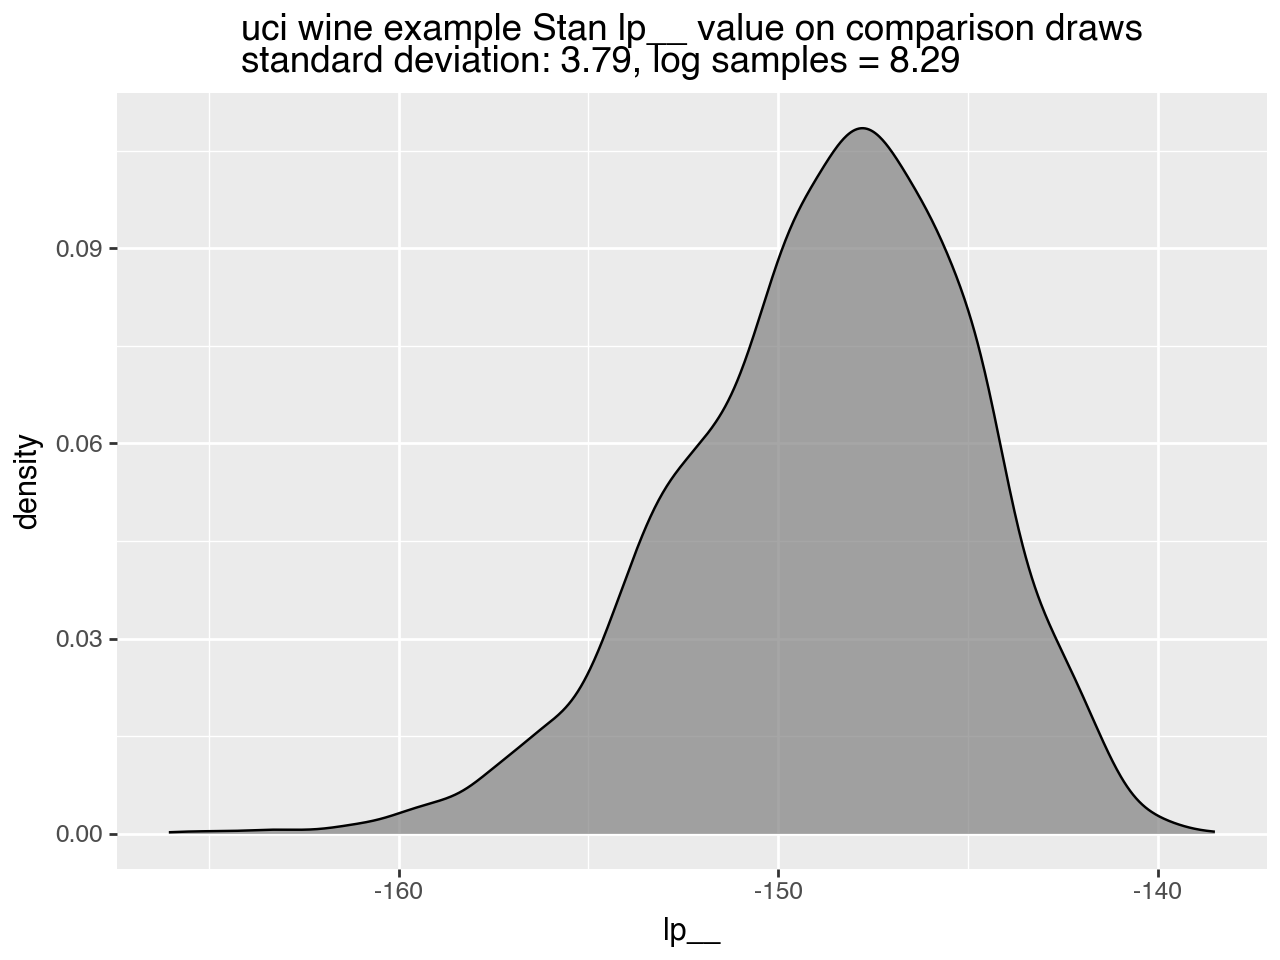

In [38]:
# get implied sample weights from chain
wt_frame_c = fit_comp.draws_pd(vars=["lp__"])
if do_display:
    stddev_c = np.sqrt(np.var(wt_frame_c["lp__"]))
    log_samples_c = np.log(wt_frame_c.shape[0])
    (
        ggplot(
            data=wt_frame_c,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on comparison draws\nstandard deviation: {stddev_c:.2f}, log samples = {log_samples_c:.2f}"
        )
    ).show()

In [39]:
beta_draws_c = fit_comp.draws_pd(vars=["beta"])
estimated_beta_Stan_c = beta_draws_c.loc[
    wt_frame_c["lp__"] >= np.quantile(wt_frame_c["lp__"], 0.5), :
].mean()
# estimated_beta_Stan_c = beta_draws_c.mean()

In [40]:
position_quantiles_c = (
    beta_draws_c.iloc[:, features_frame.shape[1] : n_vars]
    .quantile((0.25, 0.5, 0.75))
    .transpose()
    .reset_index(drop=True, inplace=False)
)
position_quantiles_c.columns = [str(c) for c in position_quantiles_c.columns]

estimated position influences


position  estimated effect  actual effect       0.25        0.5       0.75
0   posn_0         15.080480        -0.0000  11.958725  15.267700  18.404375
1   posn_1          9.584013        -0.7123   6.484245   9.648485  12.880225
2   posn_2         -2.556038        -1.4246  -5.783960  -2.509195   0.666849
3   posn_3         -8.646834        -2.1369 -12.082625  -8.716540  -5.524760
4   posn_4        -13.119658        -2.8492 -16.648425 -13.218300  -9.747238

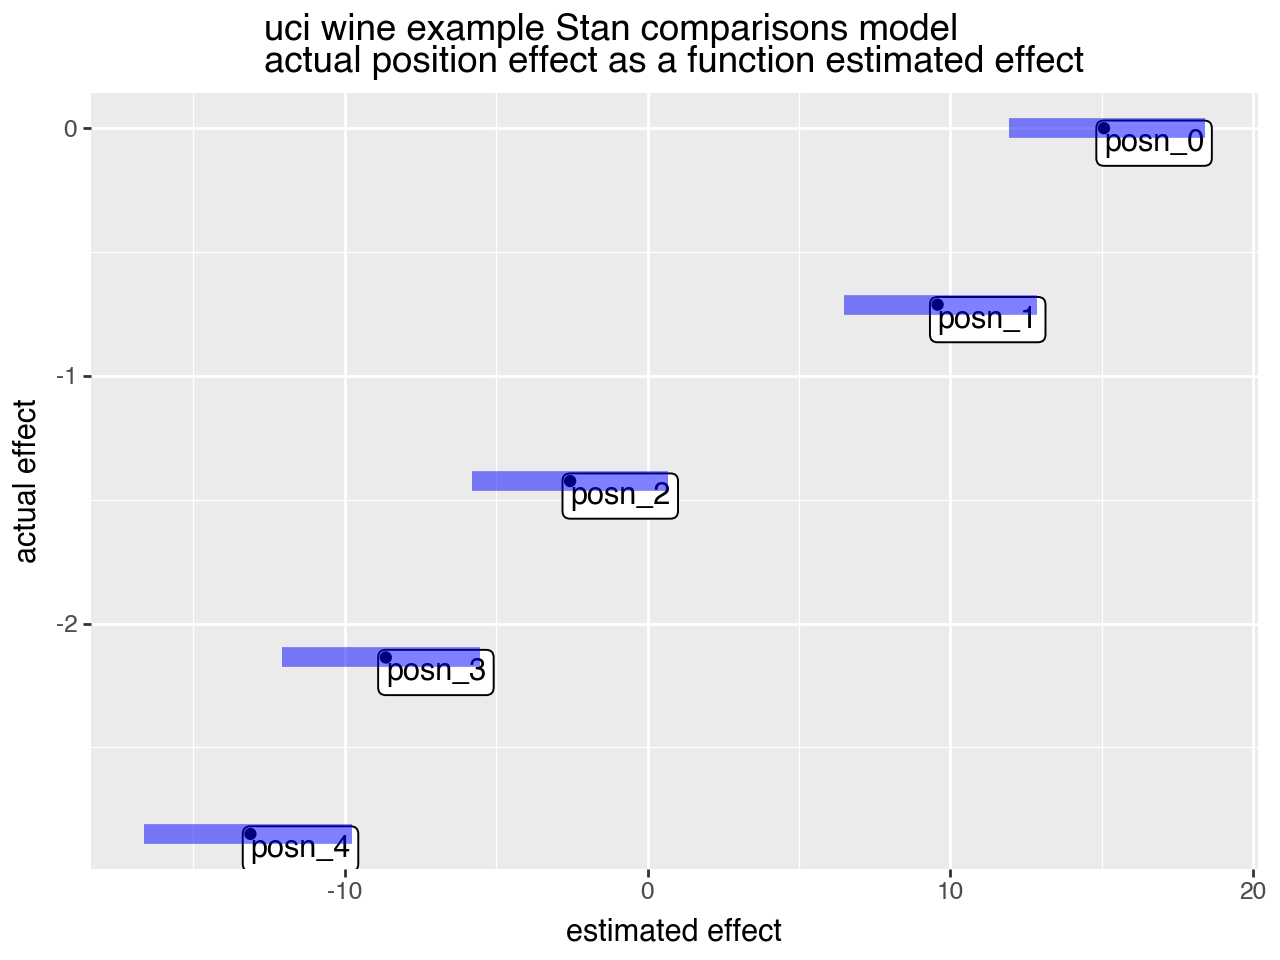

picks


row  position  pick probability estimate  was pick
0    0         0                     0.5684     False
1    0         1                     0.2399     False
2    0         2                     0.1842      True
3    0         3                     0.0067     False
4    0         4                     0.0008     False
5    1         0                     0.6000      True
6    1         1                     0.2950     False
7    1         2                     0.0182     False
8    1         3                     0.0732     False
9    1         4                     0.0136     False

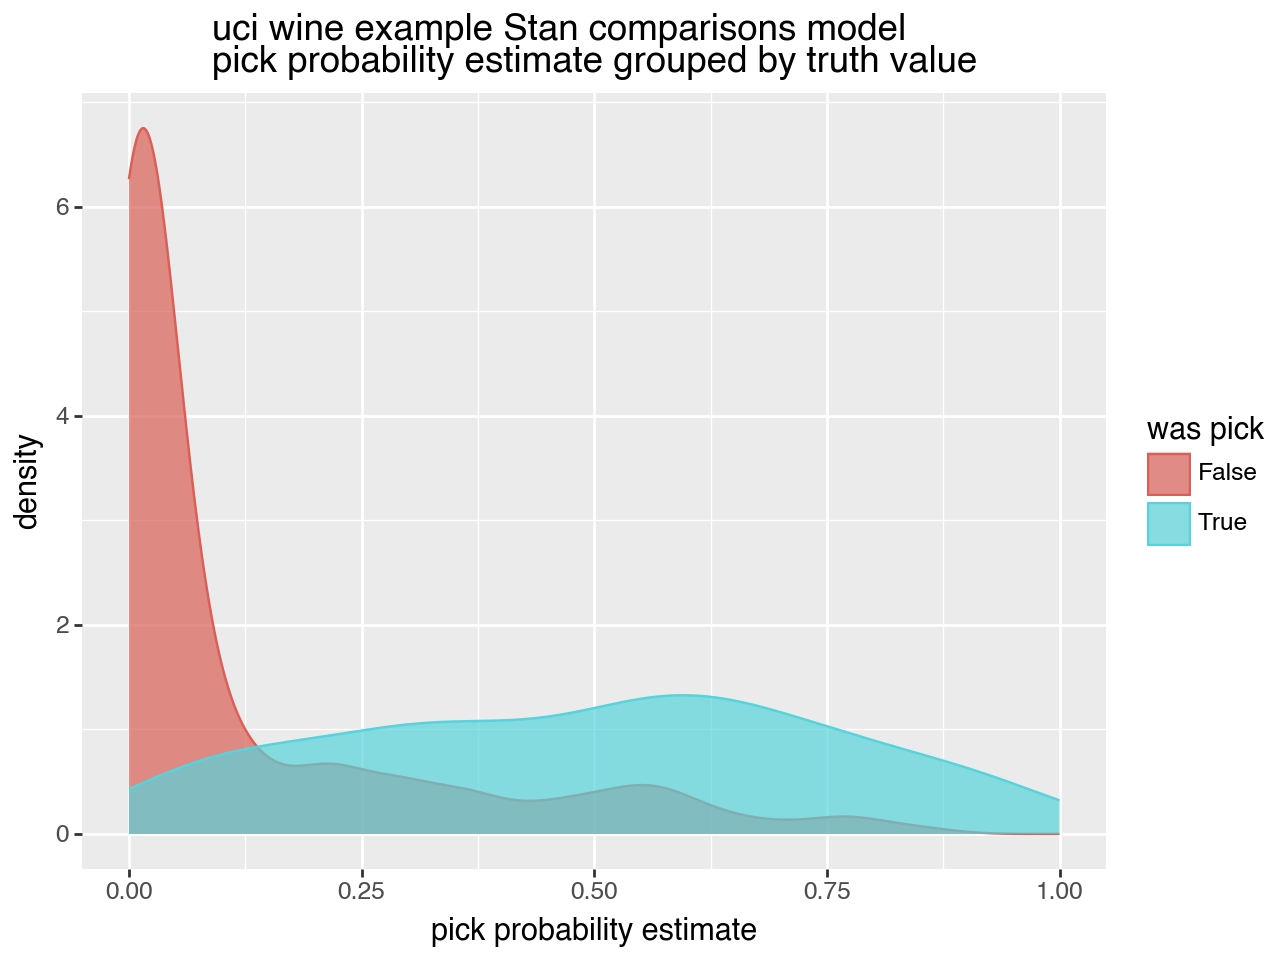

<Figure size 640x480 with 0 Axes>

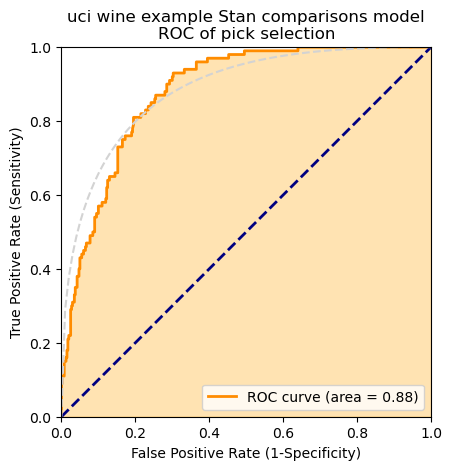

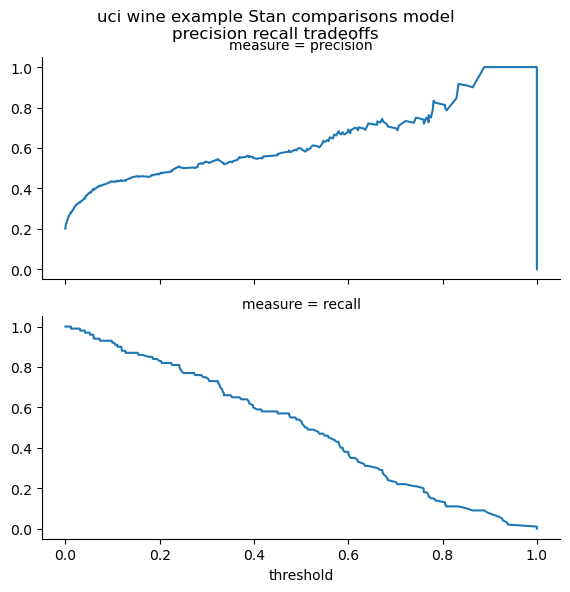

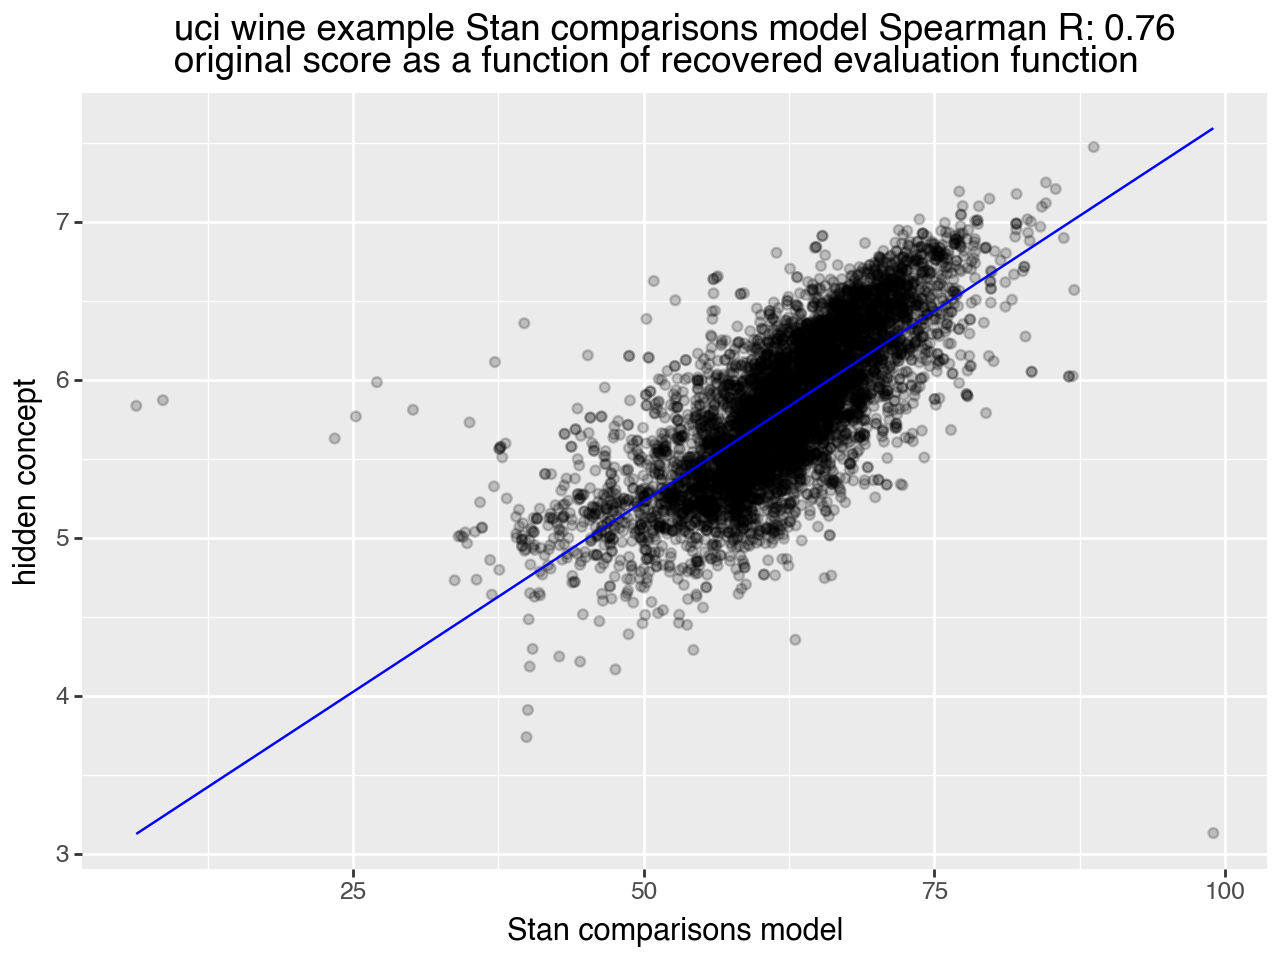

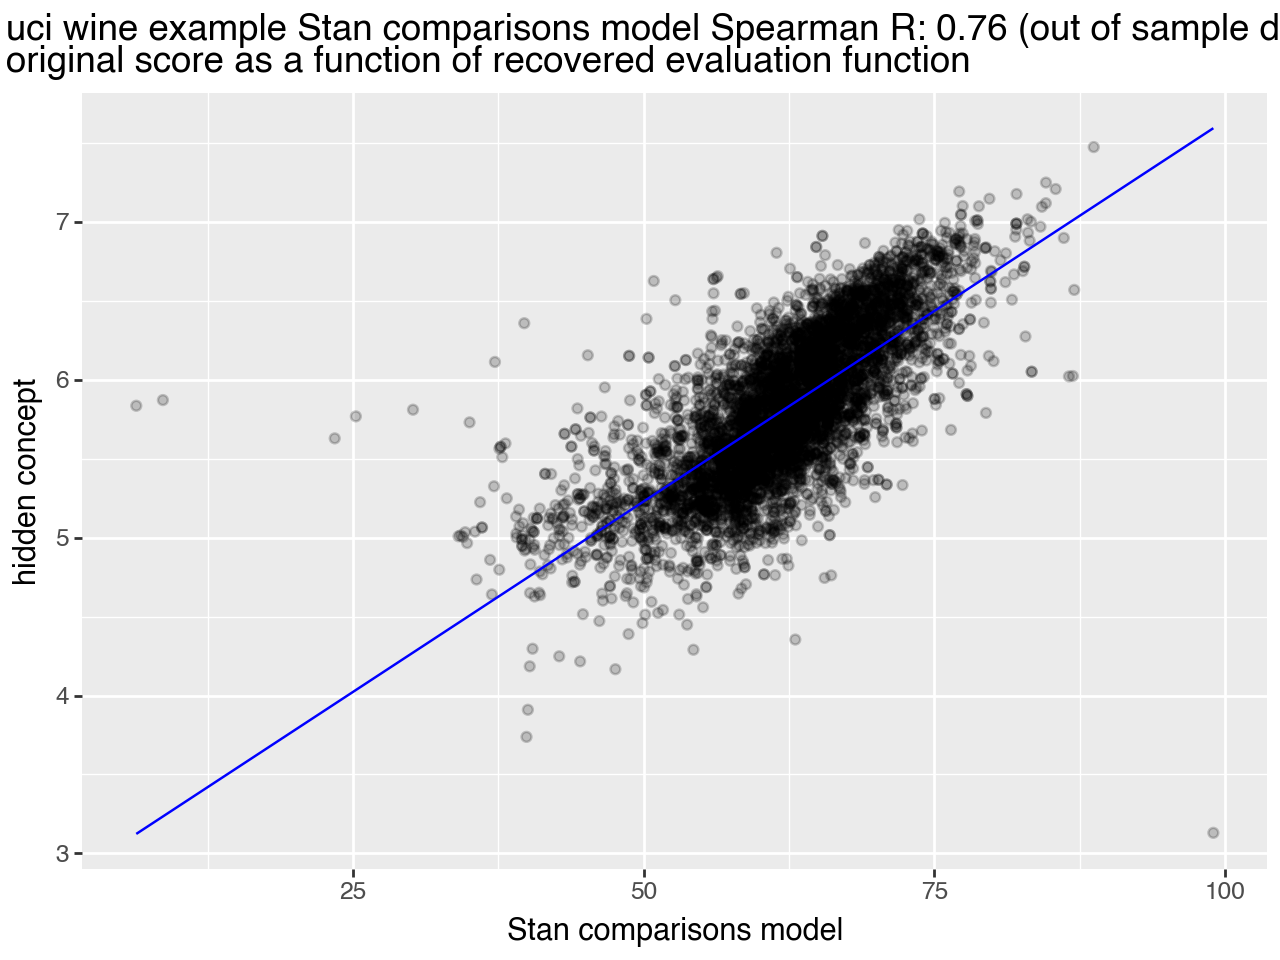

In [41]:
stat_pull = plot_rank_performance(
    estimated_beta=estimated_beta_Stan_c,  # estimated coefficients
    example_name=example_name,  # name of data set
    n_vars=n_vars,  # number of variables (including position variables)
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations=observations,  # observations layout frame
    estimate_name="Stan comparisons model",  # display name of estimate
    position_quantiles=position_quantiles_c,  # quantiles of estimated positions
    position_penalties=position_penalties,  # ideal position penalties
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

estimated position influences


position  estimated effect  actual effect
0   posn_0          1.351581        -0.0000
1   posn_1          0.790309        -0.7123
2   posn_2          0.049745        -1.4246
3   posn_3         -0.705744        -2.1369
4   posn_4         -1.485892        -2.8492

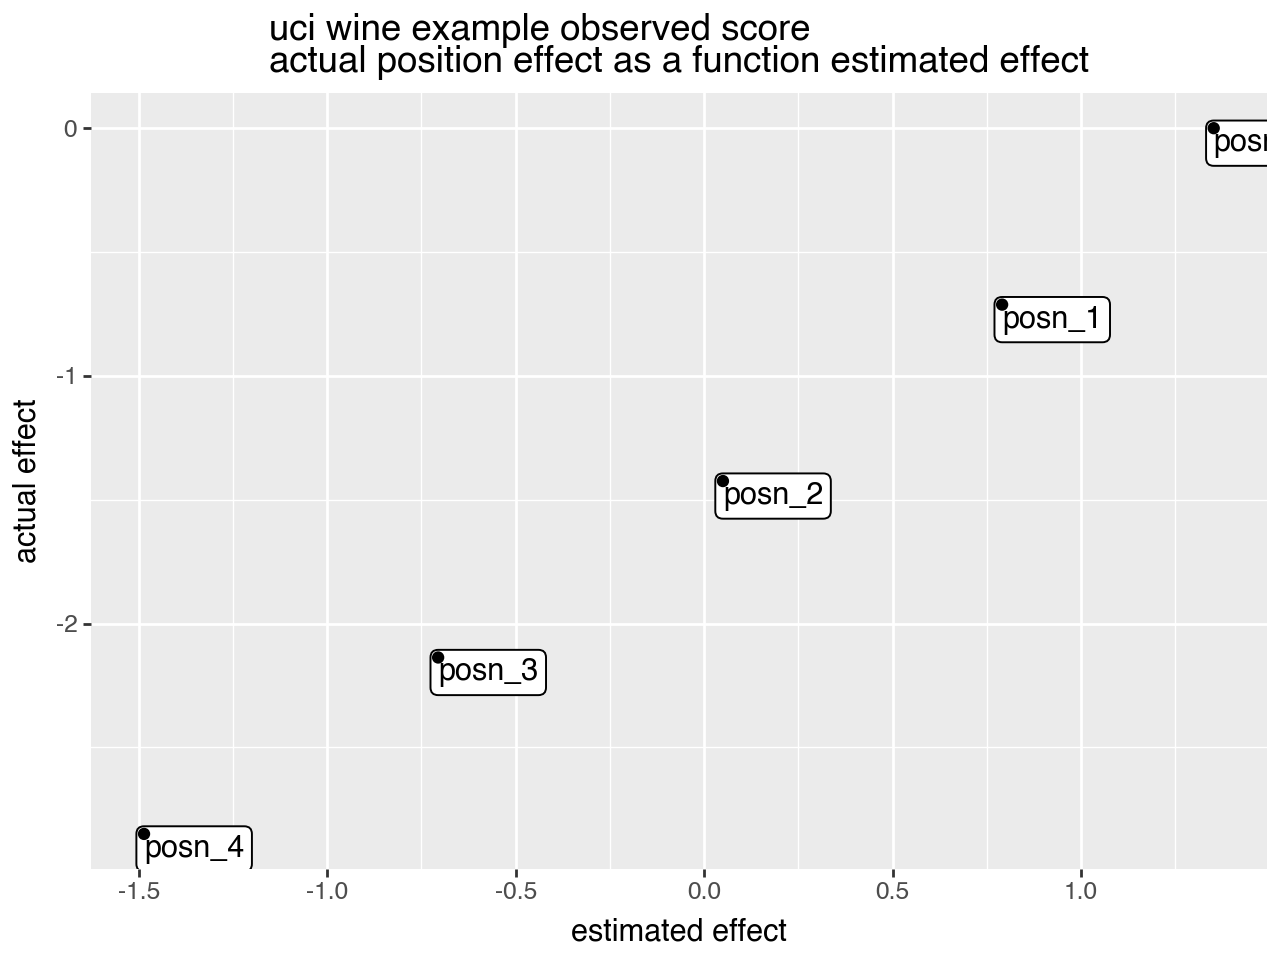

picks


row  position  pick probability estimate  was pick
0    0         0                     0.2426     False
1    0         1                     0.2151     False
2    0         2                     0.2081      True
3    0         3                     0.1755     False
4    0         4                     0.1587     False
5    1         0                     0.2348      True
6    1         1                     0.2158     False
7    1         2                     0.2001     False
8    1         3                     0.1943     False
9    1         4                     0.1550     False

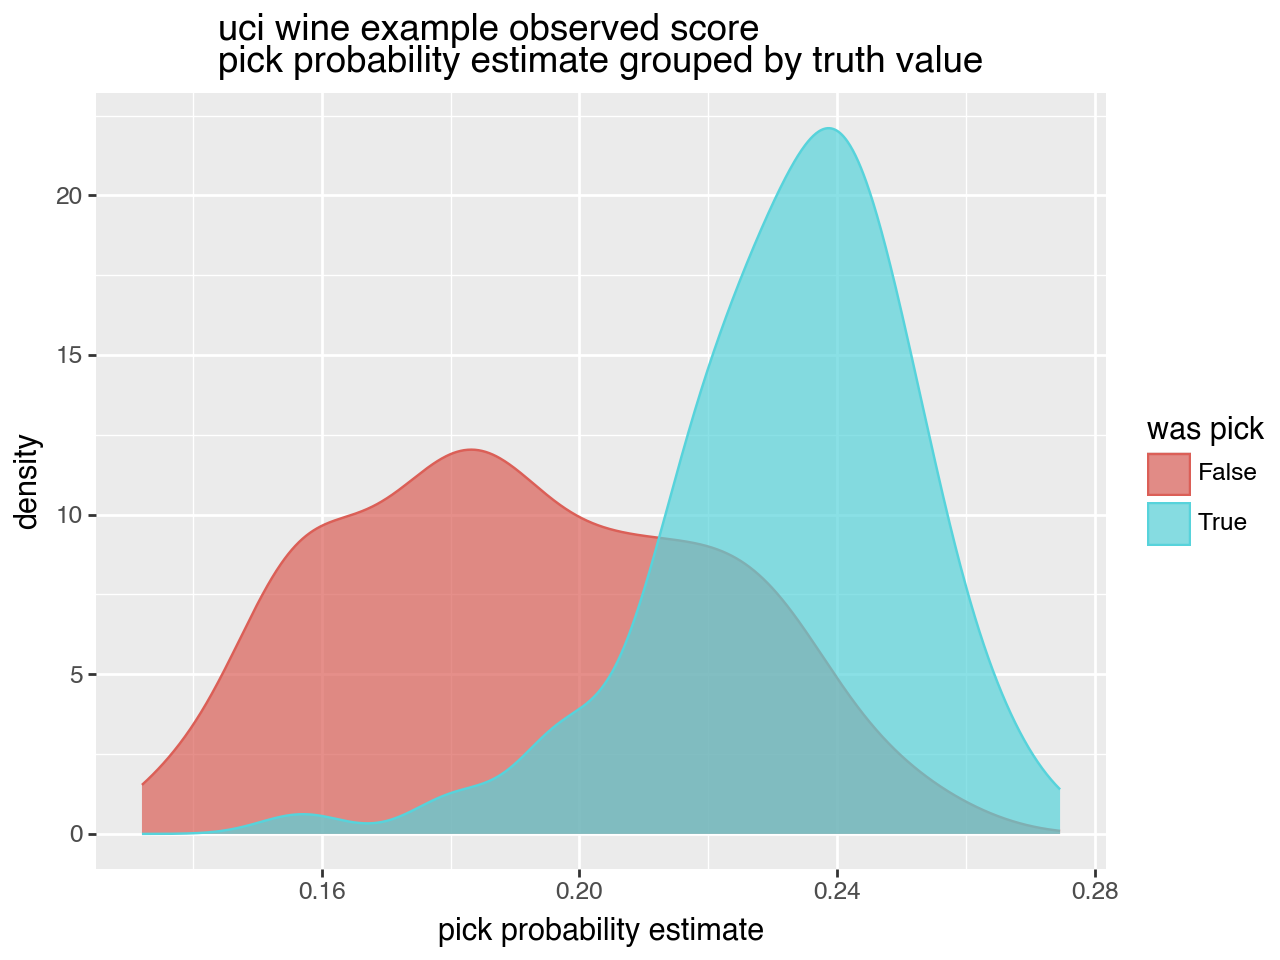

<Figure size 640x480 with 0 Axes>

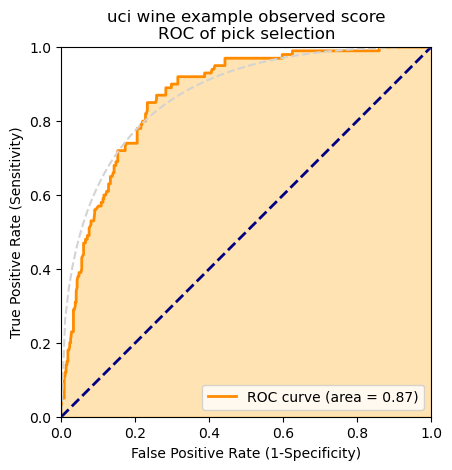

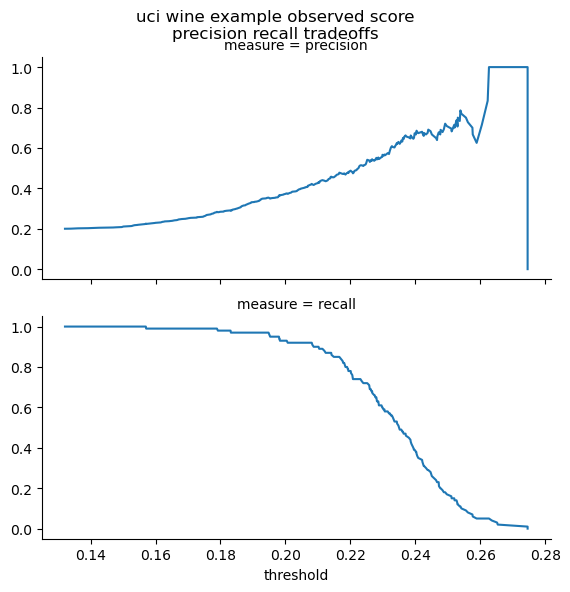

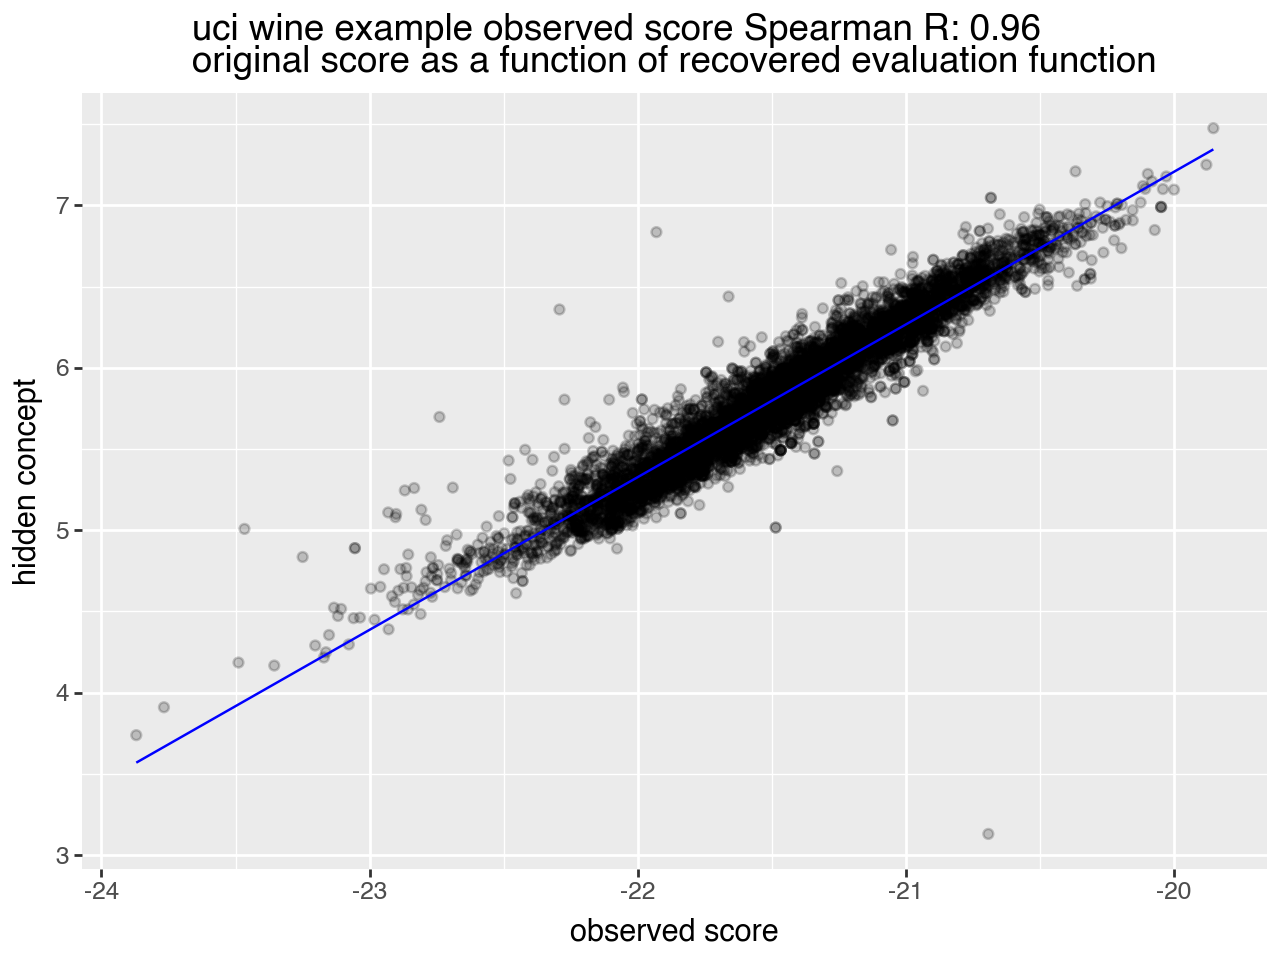

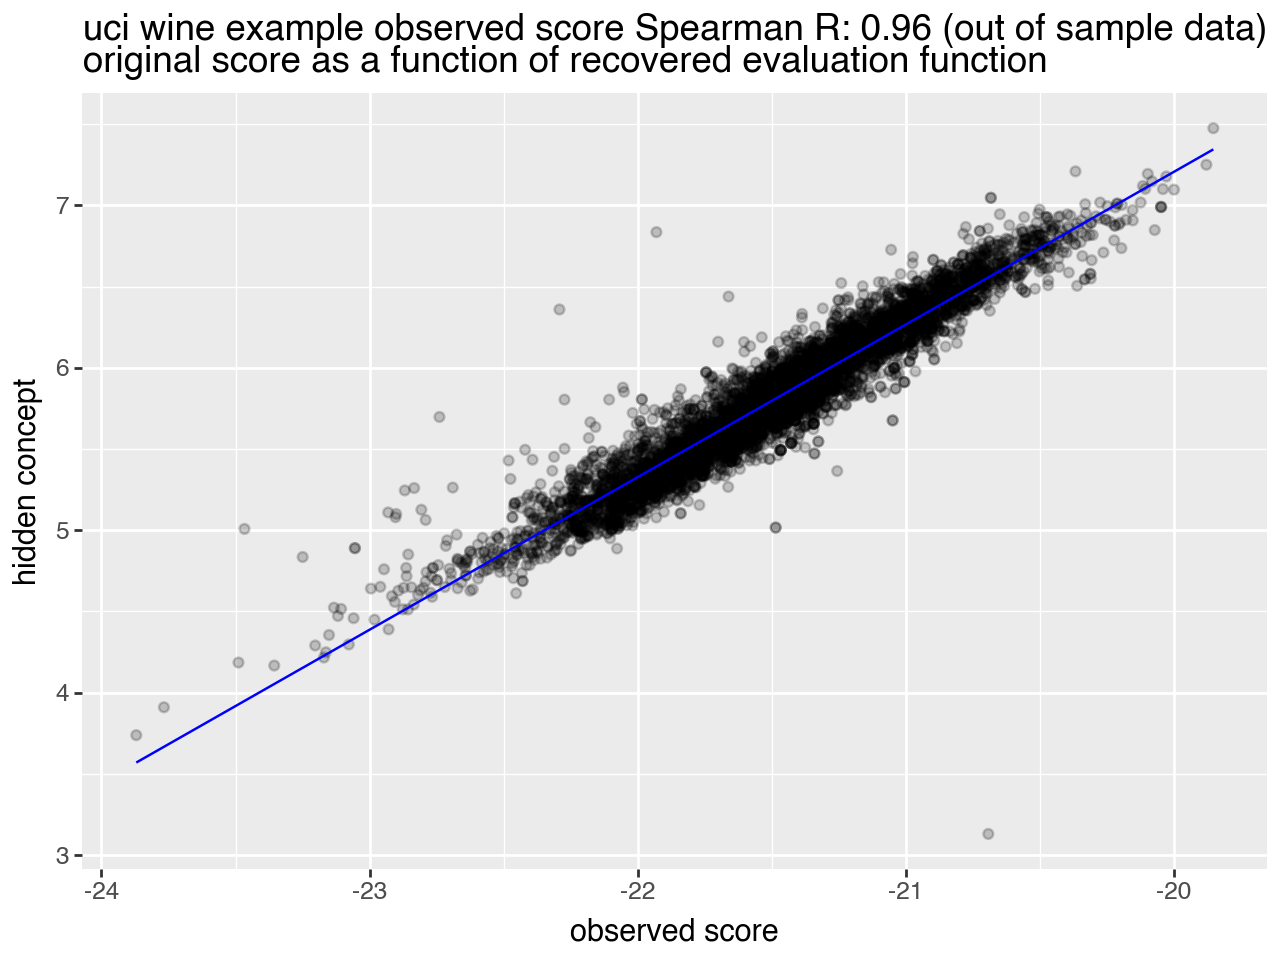

In [42]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        estimated_beta=perfect_coef,  # estimated coefficients
        example_name=example_name,  # name of data set
        n_vars=n_vars,  # number of variables (including position variables)
        n_alternatives=n_alternatives,  # size of panels
        features_frame=features_frame,  # features by row id
        observations=observations,  # observations layout frame
        estimate_name="observed score",  # display name of estimate
        position_quantiles=None,  # quantiles of estimated positions
        position_penalties=position_penalties,  # ideal position penalties
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [43]:
collected_stats = pd.concat(collected_stats, ignore_index=True)
# collected_stats['perfect_model_SpearmanR'] = perfect_model_SpearmanR

In [44]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [45]:
if do_display:
    display(collected_stats)

example_name           estimate_name  SpearmanR_all  SpearmanR_test  \
0  uci wine example        Stan panel model       0.783949        0.783787   
1  uci wine example          logistic model       0.767261        0.766748   
2  uci wine example  Stan comparisons model       0.761216        0.760708   
3  uci wine example          observed score       0.958400        0.958292   

   pick_auc  data_size  test_size  
0  0.883000       6497       6013  
1  0.878562       6497       6013  
2  0.880812       6497       6013  
3  0.869250       6497       6013